In [1]:
# ========================================
# CELL 1: Install and Import Dependencies
# ========================================
"""
Hand Tracking Prototype - Classical Computer Vision Approach
Objective: Track hand position and detect proximity to virtual boundary
Author: [Jigyashman Hazarika]
Date: December 2025
"""

# Install required packages (if needed)
# !pip install opencv-python numpy

import cv2
import numpy as np
import time
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

print("✓ Libraries imported successfully")
print(f"OpenCV Version: {cv2.__version__}")
print(f"NumPy Version: {np.__version__}")

✓ Libraries imported successfully
OpenCV Version: 4.12.0
NumPy Version: 2.2.6


In [2]:
# ========================================
# CELL 2: Configuration and Parameters
# ========================================
"""
Setting all hyperparameters and configuration settings
"""

class Config:
    # Camera settings
    CAMERA_WIDTH = 640
    CAMERA_HEIGHT = 480
    FPS_TARGET = 8
    
    # Skin color detection (HSV range)
    LOWER_SKIN = np.array([0, 20, 70], dtype=np.uint8)
    UPPER_SKIN = np.array([20, 255, 255], dtype=np.uint8)
    
    # Alternative skin range (you can tune this)
    # LOWER_SKIN = np.array([0, 48, 80], dtype=np.uint8)
    # UPPER_SKIN = np.array([20, 255, 255], dtype=np.uint8)
    
    # Virtual boundary settings (vertical line in center)
    BOUNDARY_TYPE = "line"  # Options: "line", "box", "circle"
    BOUNDARY_X = 320  # Center of 640px width
    BOUNDARY_COLOR = (0, 0, 255)  # Red (BGR)
    BOUNDARY_THICKNESS = 3
    
    # Distance thresholds (in pixels)
    SAFE_DISTANCE = 100      # > 100px = SAFE
    WARNING_DISTANCE = 50    # 50-100px = WARNING
    DANGER_DISTANCE = 50     # < 50px = DANGER
    
    # Visual settings
    STATE_COLORS = {
        'SAFE': (0, 255, 0),      # Green
        'WARNING': (0, 165, 255),  # Orange
        'DANGER': (0, 0, 255)      # Red
    }
    
    # Morphological operations
    KERNEL_SIZE = 5
    
    # FPS calculation
    FPS_BUFFER_SIZE = 30

config = Config()
print("✓ Configuration loaded")
print(f"Target FPS: {config.FPS_TARGET}")
print(f"Boundary position: x={config.BOUNDARY_X}")

✓ Configuration loaded
Target FPS: 8
Boundary position: x=320


In [3]:
# ========================================
# CELL 3: Hand Detection Functions
# ========================================
"""
Functions for detecting hand using skin color segmentation
"""

def preprocess_frame(frame):
    """
    Preprocess frame for hand detection
    Args:
        frame: BGR image from camera
    Returns:
        mask: Binary mask of skin regions
    """
    # Blur to reduce noise
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    
    # Create mask for skin color
    mask = cv2.inRange(hsv, config.LOWER_SKIN, config.UPPER_SKIN)
    
    # Morphological operations to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                      (config.KERNEL_SIZE, config.KERNEL_SIZE))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return mask


def find_hand_contour(mask):
    """
    Find the largest contour (assumed to be hand)
    Args:
        mask: Binary mask
    Returns:
        contour: Largest contour or None
        centroid: (x, y) coordinates or None
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None, None
    
    # Filter contours by area (remove noise)
    valid_contours = [c for c in contours if cv2.contourArea(c) > 1000]
    
    if not valid_contours:
        return None, None
    
    # Option 1: Find largest contour (default behavior)
    largest_contour = max(valid_contours, key=cv2.contourArea)
    
    # Option 2: Prefer contours in lower half of screen (uncomment to use)
    # This helps select hand over face if hand is positioned lower
    # frame_height = mask.shape[0]
    # lower_half_contours = []
    # for c in valid_contours:
    #     M = cv2.moments(c)
    #     if M["m00"] != 0:
    #         cy = int(M["m01"] / M["m00"])
    #         if cy > frame_height * 0.4:  # Lower 60% of frame
    #             lower_half_contours.append(c)
    # 
    # if lower_half_contours:
    #     largest_contour = max(lower_half_contours, key=cv2.contourArea)
    # else:
    #     largest_contour = max(valid_contours, key=cv2.contourArea)
    
    # Calculate centroid
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centroid = (cx, cy)
    else:
        centroid = None
    
    return largest_contour, centroid


print("✓ Hand detection functions defined")

✓ Hand detection functions defined


In [4]:
# ========================================
# CELL 4: Distance and State Logic
# ========================================
"""
Functions for calculating distance and determining state
"""

def calculate_distance_to_boundary(centroid, boundary_x):
    """
    Calculate horizontal distance from hand to boundary line
    Args:
        centroid: (x, y) tuple
        boundary_x: x-coordinate of vertical boundary
    Returns:
        distance: absolute horizontal distance
    """
    if centroid is None:
        return float('inf')
    
    cx, cy = centroid
    distance = abs(cx - boundary_x)
    return distance


def determine_state(distance):
    """
    Determine system state based on distance
    Args:
        distance: distance in pixels (or inf if no detection)
    Returns:
        state: 'SAFE', 'WARNING', or 'DANGER'
    """
    if distance == float('inf'):
        return 'SAFE'  # No hand detected = safe by default
    
    if distance > config.SAFE_DISTANCE:
        return 'SAFE'
    elif distance > config.DANGER_DISTANCE:
        return 'WARNING'
    else:
        return 'DANGER'


print("✓ Distance and state functions defined")

✓ Distance and state functions defined


In [5]:
# ========================================
# CELL 5: Visualization Functions
# ========================================
"""
Functions for drawing overlays and visual feedback
"""

def draw_boundary(frame, boundary_x):
    """Draw vertical boundary line"""
    cv2.line(frame, 
             (boundary_x, 0), 
             (boundary_x, frame.shape[0]), 
             config.BOUNDARY_COLOR, 
             config.BOUNDARY_THICKNESS)


def draw_hand_info(frame, contour, centroid, distance):
    """Draw hand contour and centroid"""
    if contour is not None:
        # Draw contour
        cv2.drawContours(frame, [contour], -1, (0, 255, 0), 2)
    
    if centroid is not None:
        # Draw centroid
        cv2.circle(frame, centroid, 10, (255, 0, 0), -1)
        
        # Draw distance line
        boundary_point = (config.BOUNDARY_X, centroid[1])
        cv2.line(frame, centroid, boundary_point, (255, 255, 0), 2)
        
        # Draw distance text (only if distance is valid)
        if distance != float('inf'):
            mid_point = ((centroid[0] + config.BOUNDARY_X) // 2, centroid[1] - 20)
            cv2.putText(frame, f"{int(distance)}px", mid_point,
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    else:
        # No hand detected - show message
        cv2.putText(frame, "No hand detected", (20, 80),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 165, 255), 2)


def draw_state_overlay(frame, state, fps):
    """Draw state information and warnings"""
    color = config.STATE_COLORS[state]
    
    # State text (top-left)
    cv2.putText(frame, f"State: {state}", (20, 40),
               cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
    
    # FPS counter (top-right)
    cv2.putText(frame, f"FPS: {fps:.1f}", (frame.shape[1] - 150, 40),
               cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
    
    # DANGER DANGER warning (center, large)
    if state == 'DANGER':
        text = "DANGER DANGER"
        font_scale = 2.0
        thickness = 5  # Increased thickness for bold effect
        
        # Get text size (using SIMPLEX font)
        (text_width, text_height), _ = cv2.getTextSize(text, 
                                                        cv2.FONT_HERSHEY_SIMPLEX, 
                                                        font_scale, thickness)
        
        # Center position
        x = (frame.shape[1] - text_width) // 2
        y = (frame.shape[0] + text_height) // 2
        
        # Draw with black background for visibility
        cv2.rectangle(frame, 
                     (x - 10, y - text_height - 10),
                     (x + text_width + 10, y + 10),
                     (0, 0, 0), -1)
        
        cv2.putText(frame, text, (x, y),
                   cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)


print("✓ Visualization functions defined")

✓ Visualization functions defined


In [6]:
# ========================================
# CELL 6: FPS Calculator
# ========================================
"""
Class for calculating real-time FPS
"""

class FPSCalculator:
    def __init__(self, buffer_size=30):
        self.timestamps = deque(maxlen=buffer_size)
        
    def update(self):
        """Update with current timestamp"""
        self.timestamps.append(time.time())
        
    def get_fps(self):
        """Calculate FPS from timestamp buffer"""
        if len(self.timestamps) < 2:
            return 0.0
        
        time_diff = self.timestamps[-1] - self.timestamps[0]
        if time_diff > 0:
            return (len(self.timestamps) - 1) / time_diff
        return 0.0

print("✓ FPS calculator defined")


✓ FPS calculator defined


In [7]:
# ========================================
# CELL 7: Main Processing Pipeline
# ========================================
"""
Main function that processes each frame
"""

def process_frame(frame, fps_calc):
    """
    Complete processing pipeline for one frame
    Args:
        frame: Input BGR frame
        fps_calc: FPS calculator instance
    Returns:
        output_frame: Annotated frame
        state: Current state
        distance: Distance to boundary
    """
    # Update FPS
    fps_calc.update()
    fps = fps_calc.get_fps()
    
    # Detect hand
    mask = preprocess_frame(frame)
    contour, centroid = find_hand_contour(mask)
    
    # Calculate distance and state
    distance = calculate_distance_to_boundary(centroid, config.BOUNDARY_X)
    state = determine_state(distance)
    
    # Create output frame
    output_frame = frame.copy()
    
    # Draw all visualizations
    draw_boundary(output_frame, config.BOUNDARY_X)
    draw_hand_info(output_frame, contour, centroid, distance)
    draw_state_overlay(output_frame, state, fps)
    
    return output_frame, state, distance, mask


print("✓ Main processing pipeline defined")

✓ Main processing pipeline defined


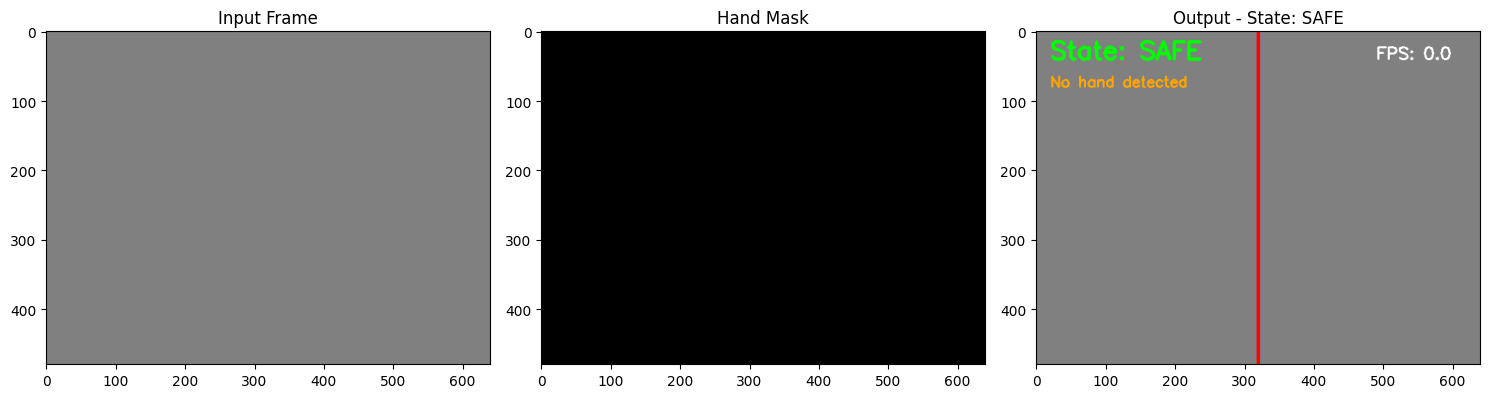

✓ Ready for testing (optional)


In [8]:
# ========================================
# CELL 8: Test with Static Image (Optional)
# ========================================
"""
Test the pipeline with a sample frame
This cell is optional - for debugging
"""

# Uncomment to test with a sample image
test_frame = np.ones((480, 640, 3), dtype=np.uint8) * 128
fps_calc = FPSCalculator()
output, state, dist, mask = process_frame(test_frame, fps_calc)
 
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
plt.title('Input Frame')
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title('Hand Mask')
plt.subplot(133)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f'Output - State: {state}')
plt.tight_layout()
plt.show()

print("✓ Ready for testing (optional)")

In [9]:
# ========================================
# CELL 9: Main Webcam Loop
# ========================================
"""
Main loop for real-time hand tracking
Press 'q' to quit
"""

def run_hand_tracking():
    """Main function to run the hand tracking system"""
    
    # Initialize camera
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, config.CAMERA_WIDTH)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, config.CAMERA_HEIGHT)
    
    if not cap.isOpened():
        print("❌ Error: Cannot open camera")
        return
    
    print("✓ Camera initialized")
    print("Press 'q' to quit")
    print("-" * 50)
    
    # Initialize FPS calculator
    fps_calc = FPSCalculator(config.FPS_BUFFER_SIZE)
    
    # Stats tracking
    frame_count = 0
    state_counts = {'SAFE': 0, 'WARNING': 0, 'DANGER': 0}
    
    try:
        while True:
            # Capture frame
            ret, frame = cap.read()
            if not ret:
                print("❌ Error: Cannot read frame")
                break
            
            # Flip frame horizontally (mirror effect)
            frame = cv2.flip(frame, 1)
            
            # Process frame
            output_frame, state, distance, mask = process_frame(frame, fps_calc)
            
            # Update stats
            frame_count += 1
            state_counts[state] += 1
            
            # Display results
            cv2.imshow('Hand Tracking POC', output_frame)
            cv2.imshow('Hand Mask (Debug)', mask)
            
            # Print stats every 30 frames
            if frame_count % 30 == 0:
                fps = fps_calc.get_fps()
                dist_str = f"{int(distance)}px" if distance != float('inf') else "N/A"
                print(f"Frame: {frame_count} | FPS: {fps:.1f} | "
                      f"State: {state} | Distance: {dist_str}")
            
            # Check for quit
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
    
    finally:
        # Cleanup
        cap.release()
        cv2.destroyAllWindows()
        
        # Print final statistics
        print("\n" + "=" * 50)
        print("SESSION SUMMARY")
        print("=" * 50)
        print(f"Total frames processed: {frame_count}")
        print(f"Average FPS: {fps_calc.get_fps():.2f}")
        print(f"\nState Distribution:")
        for state, count in state_counts.items():
            percentage = (count / frame_count * 100) if frame_count > 0 else 0
            print(f"  {state}: {count} frames ({percentage:.1f}%)")
        print("=" * 50)


# Run the system
print("\n🚀 Starting Hand Tracking System...")
print("=" * 50)

# Note: This will work in local environment
# For Colab, you'll need to use JavaScript to access webcam
run_hand_tracking()


🚀 Starting Hand Tracking System...
✓ Camera initialized
Press 'q' to quit
--------------------------------------------------
Frame: 30 | FPS: 27.1 | State: SAFE | Distance: 207px
Frame: 60 | FPS: 30.5 | State: SAFE | Distance: 218px
Frame: 90 | FPS: 28.6 | State: SAFE | Distance: 204px
Frame: 120 | FPS: 31.0 | State: SAFE | Distance: 277px
Frame: 150 | FPS: 29.2 | State: SAFE | Distance: 279px
Frame: 180 | FPS: 30.2 | State: SAFE | Distance: 289px
Frame: 210 | FPS: 30.1 | State: SAFE | Distance: 277px
Frame: 240 | FPS: 30.1 | State: DANGER | Distance: 32px
Frame: 270 | FPS: 29.3 | State: SAFE | Distance: 229px
Frame: 300 | FPS: 30.4 | State: SAFE | Distance: 179px
Frame: 330 | FPS: 29.5 | State: SAFE | Distance: 175px
Frame: 360 | FPS: 30.2 | State: SAFE | Distance: 170px
Frame: 390 | FPS: 30.2 | State: SAFE | Distance: 178px
Frame: 420 | FPS: 30.3 | State: SAFE | Distance: 123px
Frame: 450 | FPS: 29.2 | State: WARNING | Distance: 97px
Frame: 480 | FPS: 29.7 | State: WARNING | Distanc